# Base Skeleton Model
- train_model
    - epoch_step \[train\]
        - batch_step
            - preprocess
            - forward *(override 필수)*
            - criterion *(override 필수)*
            - compute_score
        - ==> 매 batch에 대해 반복
    - epoch_step \[validation\]
        - 위와 같음
    - ==> 매 epoch에 대해 반복

In [1]:
import torch
import torch.nn as nn
import time
import pickle
import os

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import pickle
import os

class BaseModel(nn.Module):
    def __init__(self, model_name='base_model'):
        super().__init__()
        self.model_name = model_name
        self.e = 0
        self.logs = {'train_loss':[], 'eval_loss':[]}
        
    def train_model(self, train_loader, test_loader, epoch, optimizer, report_intv=1, **kwargs):
        best_eval = float('inf')
        
        while True:
            if self.e >= epoch:
                break
            ts=time.time()
            
            self.train()
            train_loss, train_score = self.epoch_step(train_loader, optimizer=optimizer, **kwargs)
            self.logs['train_loss'].append(train_loss)
            
            self.eval()
            with torch.no_grad():
                eval_loss, eval_score = self.epoch_step(test_loader, **kwargs)
            self.logs['eval_loss'].append(eval_loss)
                
            if self.e%report_intv == 0:
                self.report(ts, train_loss, eval_loss, train_score, eval_score)
            self.e += 1
    
    def epoch_step(self, dataloader, optimizer=None, **kwargs):
        avg_loss = 0.0
        avg_score = 0.0
        n=0
        for batch, label, mask in dataloader:
            batch=batch.cuda().to(dtype=torch.float)
            label=label.cuda()
            if label.dtype == torch.int32:
                label = label.to(dtype=torch.long)
            elif label.dtype == torch.double:
                label = label.to(dtype=torch.float)
            mask=mask.cuda().to(dtype=torch.bool)
            
            masked_label = label.clone()
            masked_label[~mask] = -1
            
            loss, score = self.batch_step(batch, masked_label, mask, optimizer=optimizer, **kwargs)
            
            avg_loss = (n*avg_loss + loss*mask.sum().item()) / (n+mask.sum().item()+1e-10)
            avg_score = (n*avg_score + score*mask.sum().item()) / (n+mask.sum().item()+1e-10)
            n = n+mask.sum().item()#batch.shape[0]
        return avg_loss, avg_score
    
    def batch_step(self, batch, label, mask, optimizer=None):
        batch = self.preprocess(batch, label, mask)
        pred = self.forward(batch, label, mask)
        loss = self.criterion(pred, batch, label, mask)
        score = self.compute_score(pred, batch, label, mask)
        
        if self.training and (loss is not None):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        if loss is None:
            loss = 0.0
        elif isinstance(loss, torch.Tensor):
            loss = loss.item()
        if score is None:
            score = 0.0
        elif isinstance(score, torch.Tensor):
            score = score.item()
        
        return loss, score
            
    def preprocess(self, batch=None, label=None, mask=None):
        return batch
        
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        raise NotImplementedError
    
    def compute_score(self, pred=None, batch=None, label=None, mask=None):
        return None
    
    def forward(self, batch, label, mask):
        raise NotImplementedError
    
    def report(self, ts, train_loss, eval_loss, train_score, eval_score):
        if not os.path.exists('./saved_models'):
            os.mkdir('./saved_models')
        if not os.path.exists('./train_logs'):
            os.mkdir('./train_logs')

        print('(%.2fs) [Epoch %d]'%(time.time()-ts, self.e+1))
        print('\tTrain Loss : %.5g\tTrain Score : %.5g'%(train_loss, train_score))
        print('\tEval Loss : %.5g\tEval Score : %.5g'%(eval_loss, eval_score))
        torch.save(self.state_dict(), './saved_models/%s_e%d.pth'%(self.model_name, self.e+1))
        with open('./train_logs/%s.bin'%(self.model_name), 'wb') as f_log:
            pickle.dump(self.logs, f_log)
            
    def predict(self, dataloader, soft_pred=False):
        preds = []
        self.eval()
        for batch, label, mask in dataloader:
            batch=batch.cuda().to(dtype=torch.float)
            label=label.cuda()
            if label.dtype == torch.int32:
                label = label.to(dtype=torch.long)
            elif label.dtype == torch.double:
                label = label.to(dtype=torch.float)
            mask=mask.cuda().to(dtype=torch.bool)
            
            masked_label = label.clone()
            masked_label[~mask] = -1
            
            batch = self.preprocess(batch, label, mask)
            with torch.no_grad():
                pred = self.forward(batch, label, mask)
                if isinstance(pred, tuple):
                    pred = pred[0]
                
            if soft_pred:
                pred = F.softmax(pred, dim=-1)
            else:
                pred = torch.argmax(pred, dim=1)
            preds.append(pred.cpu())
        preds = torch.cat(preds, 0)
        
        return preds

## Example - Regression

In [3]:
import numpy as np
X = np.random.rand(1000,2)
print(X.shape)

(1000, 2)


In [4]:
Y = (np.sin(X[:,0]*10)+np.sin(X[:,1]*10))# + np.random.rand(500)#100*(X[:,0] + X[:,1]) + np.random.rand(200)

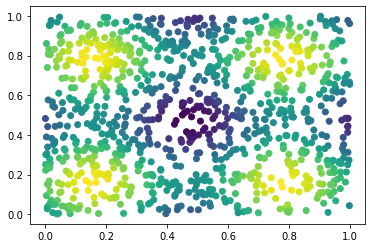

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

## !!! Method override를 통해 실험 모델 생성
- ```super()```를 통해 BaseModel의 method를 실행할 수 있음
- 수정이 필요한 method를 재정의
- !!! 모델 생성 시 주어지는 argument들은 ```__init__()``` method의 argument로 전달됨

In [44]:
class MyModel(BaseModel):
    def __init__(self, in_dim, out_dim, model_name='my_model'):
        super().__init__(model_name=model_name)
        self.fc1 = nn.Linear(in_dim,16)
        self.fc2 = nn.Linear(16,16)
        self.fc3 = nn.Linear(16,out_dim)
        self.relu = nn.ReLU()
    def forward(self, batch, label=None, mask=None):
        x = self.fc1(batch)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    def criterion(self, pred=None, batch=None, label=None, mask=None):
        return nn.MSELoss()(pred.view(-1),label)
    

#### !!! 배치 사이즈 (BATCH), 에폭 수 (EPOCH), learning rate (LR) 정의

In [59]:
BATCH = 16
EPOCH = 200
LR = 1e-2

In [60]:
model = MyModel(2,1)
model.cuda()

MyModel(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

## Dataset, DataLoader
- 모든 실습에서는 pytorch의 Dataset, DataLoader를 통해 배치 데이터를 로드함
- 각 배치 데이터는 batch, label, mask의 묶음으로 이루어짐
    - batch : input 데이터
    - label : ground-truth label
    - mask : 학습 시 label이 주어지는 지 여부 (unsupervised, semi-supervised에서 해당)

In [61]:
from torch.utils.data import DataLoader, Dataset
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, index):
        return self.X[index], self.Y[index], True

In [62]:
train_dataset = MyDataset(X[:100], Y[:100])
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH)
test_dataset = MyDataset(X[100:], Y[100:])
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [63]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), LR)

In [64]:
model.train_model(train_loader, test_loader, EPOCH, optimizer, report_intv=10)

(0.04s) [Epoch 1]
	Train Loss : 0.98645	Train Score : 0
	Eval Loss : 0.91263	Eval Score : 0
(0.04s) [Epoch 11]
	Train Loss : 0.82453	Train Score : 0
	Eval Loss : 0.82259	Eval Score : 0
(0.04s) [Epoch 21]
	Train Loss : 0.7337	Train Score : 0
	Eval Loss : 0.7359	Eval Score : 0
(0.04s) [Epoch 31]
	Train Loss : 0.61452	Train Score : 0
	Eval Loss : 0.59113	Eval Score : 0
(0.04s) [Epoch 41]
	Train Loss : 0.50614	Train Score : 0
	Eval Loss : 0.47213	Eval Score : 0
(0.04s) [Epoch 51]
	Train Loss : 0.32695	Train Score : 0
	Eval Loss : 0.38845	Eval Score : 0
(0.04s) [Epoch 61]
	Train Loss : 0.26101	Train Score : 0
	Eval Loss : 0.34234	Eval Score : 0
(0.04s) [Epoch 71]
	Train Loss : 0.22485	Train Score : 0
	Eval Loss : 0.34077	Eval Score : 0
(0.04s) [Epoch 81]
	Train Loss : 0.21996	Train Score : 0
	Eval Loss : 0.3206	Eval Score : 0
(0.04s) [Epoch 91]
	Train Loss : 0.21308	Train Score : 0
	Eval Loss : 0.35817	Eval Score : 0
(0.04s) [Epoch 101]
	Train Loss : 0.18092	Train Score : 0
	Eval Loss : 0.3

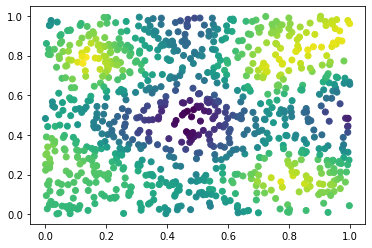

In [65]:
X_test = torch.from_numpy(X[100:]).to(device='cuda',dtype=torch.float)
with torch.no_grad():
    pred = model(X_test)

X_test = X_test.cpu()
plt.scatter(X_test[:,0], X_test[:,1], c=pred.cpu())
plt.show()